In [ ]:
!pip install tensorflow==2.9

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model


In [ ]:
print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

# Data Preperation

In [ ]:
labels = ['glioma','meningioma', 'notumor', 'pituitary']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [33]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive','Training_big',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

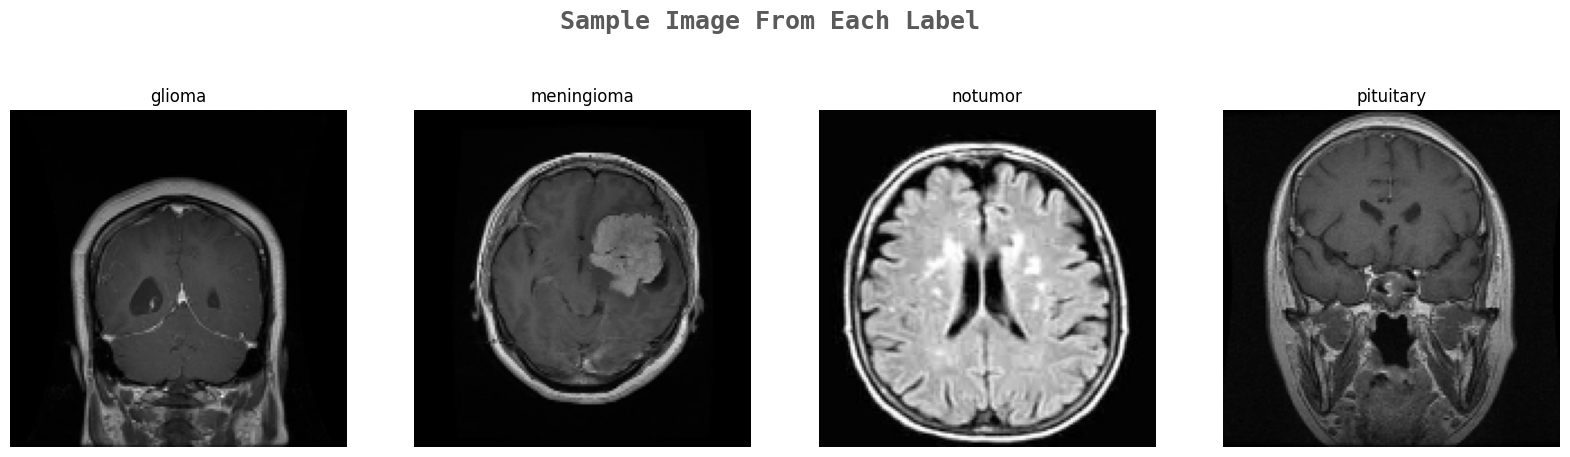

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


# y_test_new = []
# for i in y_test:
#     y_test_new.append(labels.index(i))
# y_test = y_test_new
# y_test = tf.keras.utils.to_categorical(y_test)

---

In [ ]:
effnet = EfficientNetB7(weights='imagenet', include_top=False)
effnet.trainable = True

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
inputs = layers.Input(shape=(image_size, image_size, 3), name="input_layer") # shape of input image
model= data_augmentation(inputs)
model= effnet(model,training=True)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=inputs, outputs = model)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 4)                 10244 

We finally compile our model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("best_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[checkpoint,reduce_lr])

Epoch 1/20
161/161 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8519
Epoch 1: val_accuracy improved from -inf to 0.88986, saving model to best_model.h5
161/161 [==============================] - 331s 2s/step - loss: 0.4289 - accuracy: 0.8519 - val_loss: 0.2619 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 2/20
161/161 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9200
Epoch 2: val_accuracy improved from 0.88986 to 0.95105, saving model to best_model.h5
161/161 [==============================] - 216s 1s/step - loss: 0.2298 - accuracy: 0.9200 - val_loss: 0.1572 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 3/20
161/161 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9397
Epoch 3: val_accuracy did not improve from 0.95105
161/161 [==============================] - 195s 1s/step - loss: 0.1881 - accuracy: 0.9397 - val_loss: 0.1770 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 4/20
161/161 [==============================] - ETA

# Prediction

# Evaluation

In [ ]:
model = load_model('best_model.h5')

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

# Submission

In [ ]:
X_train_val = []
L5 = []
folderPath = os.path.join('/content/drive/MyDrive','Testing_small')
for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size,image_size))
    X_train_val.append(img)
    L5.append(j.replace(".jpg", ""))

100%|██████████| 480/480 [00:06<00:00, 73.37it/s] 


In [ ]:
X_train_val = np.array(X_train_val)

In [ ]:
pred_val = model.predict(X_train_val)
pred_val = np.argmax(pred_val,axis=1)
pred_val

15/15 [==============================] - 8s 180ms/step


array([2, 2, 1, 2, 1, 0, 3, 0, 3, 3, 3, 0, 3, 0, 1, 2, 3, 1, 2, 1, 2, 2,
       2, 2, 0, 0, 1, 2, 1, 3, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 2, 0,
       2, 2, 3, 0, 1, 2, 3, 1, 2, 0, 1, 3, 3, 1, 2, 1, 3, 2, 0, 2, 2, 3,
       2, 2, 0, 3, 1, 3, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 3, 1, 2, 0, 0,
       0, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 2, 0, 0, 1,
       2, 0, 1, 1, 2, 0, 0, 2, 3, 2, 1, 1, 2, 2, 1, 2, 0, 3, 0, 2, 3, 0,
       2, 3, 0, 2, 0, 3, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 3, 1, 2, 1, 1, 0,
       3, 0, 1, 0, 3, 0, 3, 0, 3, 1, 1, 2, 1, 1, 3, 1, 0, 3, 2, 1, 1, 2,
       3, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 1, 3, 1, 3, 2, 2, 0, 1, 2, 2, 0,
       3, 3, 3, 3, 3, 2, 1, 3, 2, 1, 1, 3, 3, 0, 2, 0, 3, 0, 2, 2, 1, 1,
       3, 2, 2, 3, 1, 0, 2, 3, 2, 2, 2, 2, 0, 3, 3, 2, 2, 2, 1, 1, 3, 1,
       1, 1, 2, 0, 1, 3, 1, 2, 0, 3, 3, 0, 0, 1, 0, 3, 0, 3, 1, 1, 3, 3,
       3, 2, 3, 2, 2, 0, 3, 3, 3, 0, 1, 2, 2, 3, 2, 2, 1, 3, 0, 1, 3, 3,
       2, 2, 0, 0, 1, 2, 1, 2, 0, 3, 3, 0, 1, 3, 0,

In [ ]:
# Generate ID column


# Create a list of labels with the same length as the ID column
# labels = ['label{}'.format(i) for i in range(1, 481)]

# Create the DataFrame
df = pd.DataFrame({'ID': L5, 'Label': pred_val})

df.to_csv('trainnn.csv', index=False)

---